# Transfer learning   
### Based on:   
https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

In [1]:
import sys
import numpy as np
import h5py
import copy
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


## Read data. Make train and test sets

In [3]:
def readScan(scanName):
    data=h5py.File(scanName,'r')
    Xscans=data.get('Xnew')
    X=copy.copy(Xscans.value)
    X1=np.rollaxis(X,0,start=3)
    return X1

In [61]:
n_echoes=100
skip_rows=3 # the first 50 description files have a different format 

X=[]
y=[]

for idx,i in enumerate(np.arange(n_echoes)+1):
    scan_file_name='../Data100/cardio{0}.mat'.format(i)
    X.append(readScan(scan_file_name))
    # the first 50 description files have a different format 
    if i==51:
        skip_rows=0
    labels=pd.read_csv('../Data100/PD_ANN0%03d.csv' % (i), skiprows=skip_rows)
    # Criteria to determine whether a polar map does not have risk = 0 or has risk = 1
    LAD=labels['Reserve mean'][0]
    LCX=labels['Reserve mean'][1]
    RCA=labels['Reserve mean'][2]
    y_temp=[0 if LAD > 2 and LCX > 2 and RCA > 2 else 1]
    y.append(y_temp[0])

In [62]:
train_test_ratio=.7
train_size=int(n_echoes*train_test_ratio)
rand_samples=random.sample(range(0,n_echoes),n_echoes)

In [63]:
# permute the samples
X=[X[i] for i in rand_samples]
y=[y[i] for i in rand_samples]

In [64]:
X_train=[X[i] for i in rand_samples[:train_size]]
X_test=[X[i] for i in rand_samples[train_size:]]
y_train=[y[i] for i in rand_samples[:train_size]]
y_test=[y[i] for i in rand_samples[train_size:]]
print(np.shape(X_train),np.shape(X_test))
print(np.shape(y_train),np.shape(y_test))

(70, 223, 223, 3) (30, 223, 223, 3)
(70,) (30,)


In [65]:
# Format for keras
X=np.array(X)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
from keras.utils import to_categorical
y=np.array(y)
y=to_categorical(y, num_classes=2)
y_train=np.asarray(y_train)
y_train=to_categorical(y_train, num_classes=2)
y_test=np.asarray(y_test)
y_test=to_categorical(y_test, num_classes=2)

In [66]:
np.sum(y,0)

array([ 64.,  36.])

(70, 223, 223, 3)

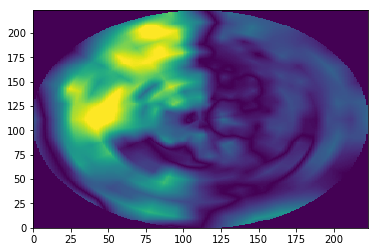

In [13]:
plt.pcolor(X_train[5][:,:,1])
np.shape(X_train)

---

## Add padding to match inception shape

(100, 223, 223, 3)


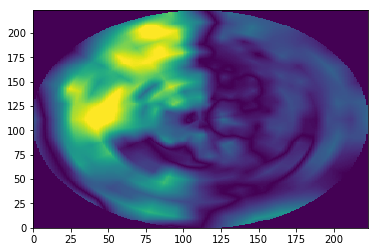

In [14]:
x5=X_train[5]
plt.pcolor(x5[:,:,1])
print(np.shape(X))

In [15]:
# For our nn we need images of 299x299
pixels_to_add=int((299-223)/2)
print('Adding {0} pixels on each side'.format(pixels_to_add))

Adding 38 pixels on each side


In [16]:
padding=((pixels_to_add,pixels_to_add),(pixels_to_add,pixels_to_add),(0,0))
X_train=[np.pad(i,padding,mode='constant', constant_values=0) for i in X_train]
X_test=[np.pad(i,padding,mode='constant', constant_values=0) for i in X_test]

(100, 223, 223, 3)


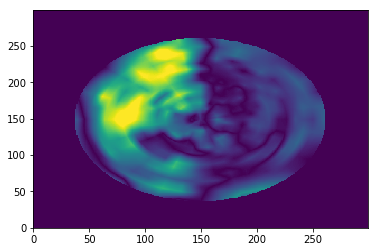

In [17]:
x5=X_train[5]
plt.pcolor(x5[:,:,1])
print(np.shape(X))

# Get pretrained model

In [38]:
# base_model = applications.InceptionV3(weights='imagenet', include_top=False)

87851008/87910968 [============================>.] - ETA: 0s

In [92]:
# base_model = applications.VGG19(weights = "imagenet", include_top=False)

80019456/80134624 [============================>.] - ETA: 0s

In [39]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# serialize model to JSON
# model_json = base_model.to_json()
# with open("model_InceptionV3.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# base_model.save_weights("model_InceptionV3.h5")
# print("Saved model to disk")

Saved model to disk


In [18]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# load json and create model
from keras.models import model_from_json
json_file = open('model_InceptionV3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
base_model = model_from_json(loaded_model_json)
# load weights into new model
base_model.load_weights("model_InceptionV3.h5")
print("Loaded model from disk")

Loaded model from disk


---

# Functions   
https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine-tune.py

In [40]:
# https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet
  Args:
    base_model: keras model excluding top
    nb_classes: # of classes
  Returns:
    new keras model with last layer
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) 
  predictions = Dense(nb_classes, activation='softmax')(x) 
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [41]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='rmsprop',    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [42]:
def setup_to_finetune(model):
   """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top 
      layers.
   note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in 
         the inceptionv3 architecture
   Args:
     model: keras model
   """
   for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
      layer.trainable = False
   for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
      layer.trainable = True
   model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),   
                 loss='categorical_crossentropy',
                metrics=['accuracy'])

---

In [22]:
nb_classes=2
FC_SIZE = 1024
NB_EPOCHS = 10
BAT_SIZE = 32
NB_IV3_LAYERS_TO_FREEZE = 172

In [43]:
# setup model
model = add_new_last_layer(base_model, nb_classes)

In [44]:
# transfer learning
setup_to_transfer_learn(model, base_model)

In [67]:
history_lr=model.fit(X,y,batch_size=BAT_SIZE,
                  epochs=NB_EPOCHS,shuffle=False,
                    validation_split=.3)

Train on 70 samples, validate on 30 samples
Epoch 1/3
70/70 [==============================] - 53s - loss: 5.7565 - acc: 0.6429 - val_loss: 5.9100 - val_acc: 0.6333
Epoch 2/3
70/70 [==============================] - 51s - loss: 5.7565 - acc: 0.6429 - val_loss: 5.9100 - val_acc: 0.6333
Epoch 3/3
70/70 [==============================] - 49s - loss: 5.7565 - acc: 0.6429 - val_loss: 5.9100 - val_acc: 0.6333


In [68]:
 # fine-tuning
setup_to_finetune(model)

In [69]:
history_ft=model.fit(X,y,batch_size=BAT_SIZE,
                  epochs=NB_EPOCHS,shuffle=False,
                    validation_split=.3)

Train on 70 samples, validate on 30 samples
Epoch 1/3
70/70 [==============================] - 55s - loss: 5.7565 - acc: 0.6429 - val_loss: 5.9100 - val_acc: 0.6333
Epoch 2/3
70/70 [==============================] - 56s - loss: 5.7565 - acc: 0.6429 - val_loss: 5.9100 - val_acc: 0.6333
Epoch 3/3
70/70 [==============================] - 51s - loss: 5.7565 - acc: 0.6429 - val_loss: 5.9100 - val_acc: 0.6333


In [51]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
plt.show()

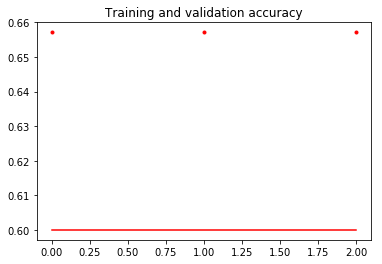

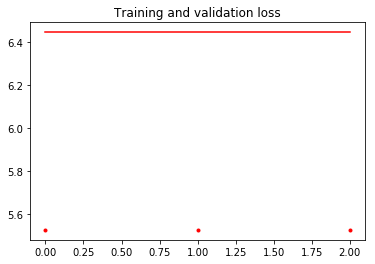

In [52]:
plot_training(history_ft)

In [41]:
yy=to_categorical(y_train, num_classes=2)

In [42]:
yy

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,

In [38]:
np.shape(np.array(y_train))

(70,)

---

In [17]:
nb_classes=2
FC_SIZE = 1024

In [40]:
# setup model
#base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
model = add_new_last_layer(base_model, nb_classes)

/home/oc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [41]:
setup_to_transfer_learn(model, base_model)

In [42]:
history_tl=model.fit(X_train,y_train,epochs=2)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 70 arrays: [array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,...